In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imgw_api import get_hydro_metadata,get_meteo_metadata
from imgw_static import get_map_wojewodztwa
from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils_maps import plot_zlewnia_stat

### Wczytanie Danych

In [2]:
zlewnie = gpd.read_file('../static_data/zlewnie/zlewnie_2.gpkg')
zlewnie = zlewnie.rename(columns={"objectid" : "Zlewnia ID"})
meteo = pd.read_parquet("../static_data/filtered_meteo_opad_data.parquet.gzip")
hydro = pd.read_parquet("../static_data/filtered_hydro_data.parquet.gzip")
gdf_h = get_hydro_metadata(True)
gdf_m = get_meteo_metadata(True)

### Analiza Danych Hydrologicznych na poziomie Zlewni - 2

In [3]:
# Dołączenie stacji hydrologicznych do zlewni
gdf_h_zlewnia = gpd.sjoin(gdf_h, zlewnie, how='inner', predicate='within').drop(['naz_zlewni','id_hyd_10','id_hyd_50','guid'],axis=1)

In [4]:
gdf_h_zlewnia

,Station Code,Station Name,Lon,Lat,geometry,index_right,pow,Zlewnia ID,st_area(shape),st_perimeter(shape)
10,150170080,JARNOŁTÓWEK,17.428056,50.285833,POINT (388048.876 269921.394),0,1.341904e+10,1,1.342844e+10,831947.426343
12,150180090,NĘDZA,18.310556,50.157778,POINT (450766.450 254733.345),0,1.341904e+10,1,1.342844e+10,831947.426343
13,150180140,RYBNIK,18.533056,50.102500,POINT (466616.779 248465.912),0,1.341904e+10,1,1.342844e+10,831947.426343
14,150180230,WESOŁA,18.690000,50.561667,POINT (478049.721 299447.307),0,1.341904e+10,1,1.342844e+10,831947.426343
15,150180250,KŁODNICA,18.864167,50.236667,POINT (490316.027 263283.634),0,1.341904e+10,1,1.342844e+10,831947.426343
...,...,...,...,...,...,...,...,...,...,...
488,154190010,NOWY DWÓR GDAŃSKI,19.113056,54.214444,POINT (507370.415 705584.196),31,8.539384e+08,31,8.545366e+08,277506.194777
489,154190020,TUJSK,19.138333,54.284167,POINT (509003.091 713342.531),31,8.539384e+08,31,8.545366e+08,277506.194777
656,150160040,KUDOWA-ZDRÓJ-ZAKRZE,16.243889,50.430833,POINT (304321.268 288487.062),47,6.070069e+08,56,6.074321e+08,170360.482512
817,154160030,KOSZALIN,16.188889,54.185556,POINT (316631.609 706014.055),26,7.942801e+08,26,7.948365e+08,247594.085722


Mapowanie Id Zlewnie do danych pomiarowych

In [5]:
map_hydro = gdf_h_zlewnia.set_index('Station Code')['Zlewnia ID']
hydro['Zlewnia ID'] = hydro['Station Code'].map(map_hydro)

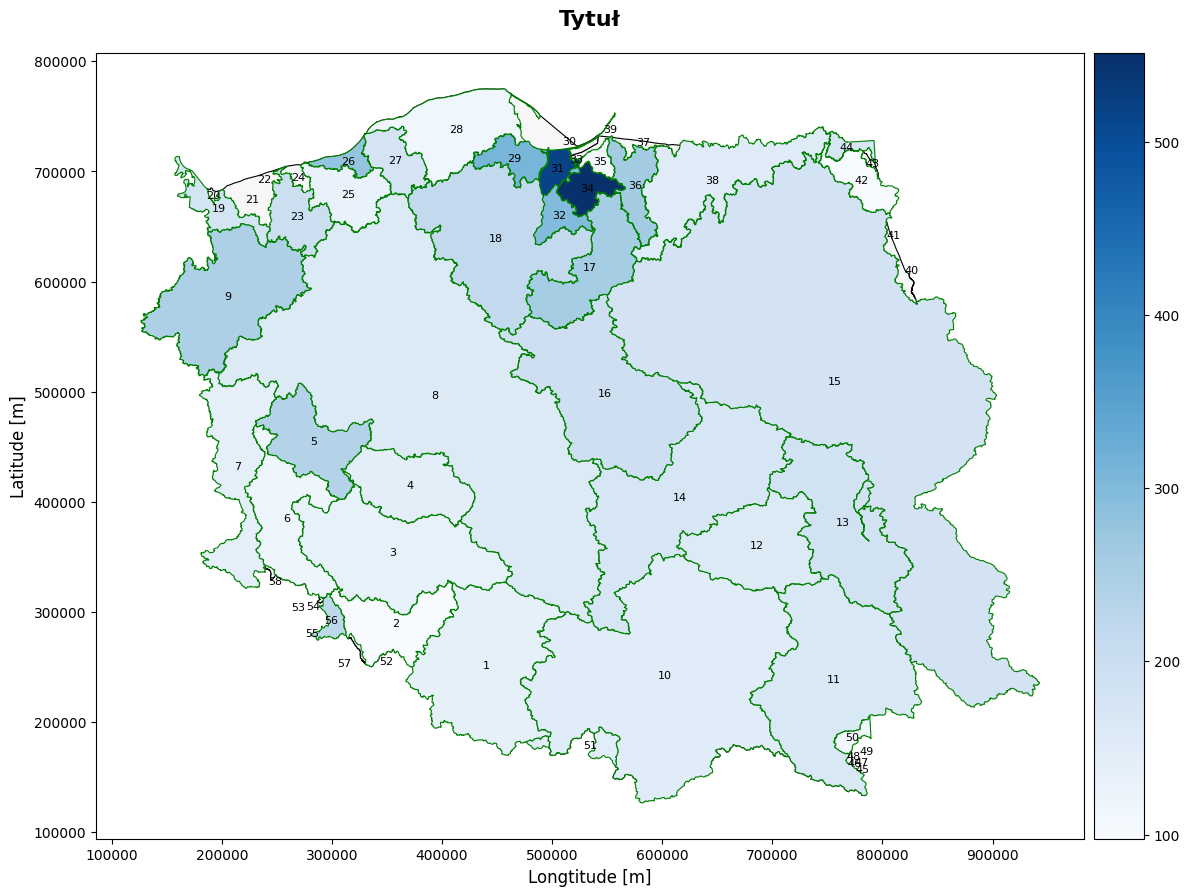

In [32]:
# Województwa
woj = get_map_wojewodztwa()

# Agregacja
agg_hydro = hydro.groupby("Zlewnia ID")[["Water Level", "Flow"]].agg(['mean', 'max', 'min','median'])
agg_hydro.columns = ['_'.join(col) for col in agg_hydro.columns]
agg_hydro.reset_index(inplace=True)

# Wykres
plot_zlewnia_stat(zlewnie, woj, agg_hydro, 'Water Level_mean', 'Tytuł')


In [18]:
id = 15
wl_series2 = hydro[hydro["Zlewnia ID"] == id].groupby("Calendar Date")["Water Level"].mean()
wl_series2 = wl_series2.reset_index()

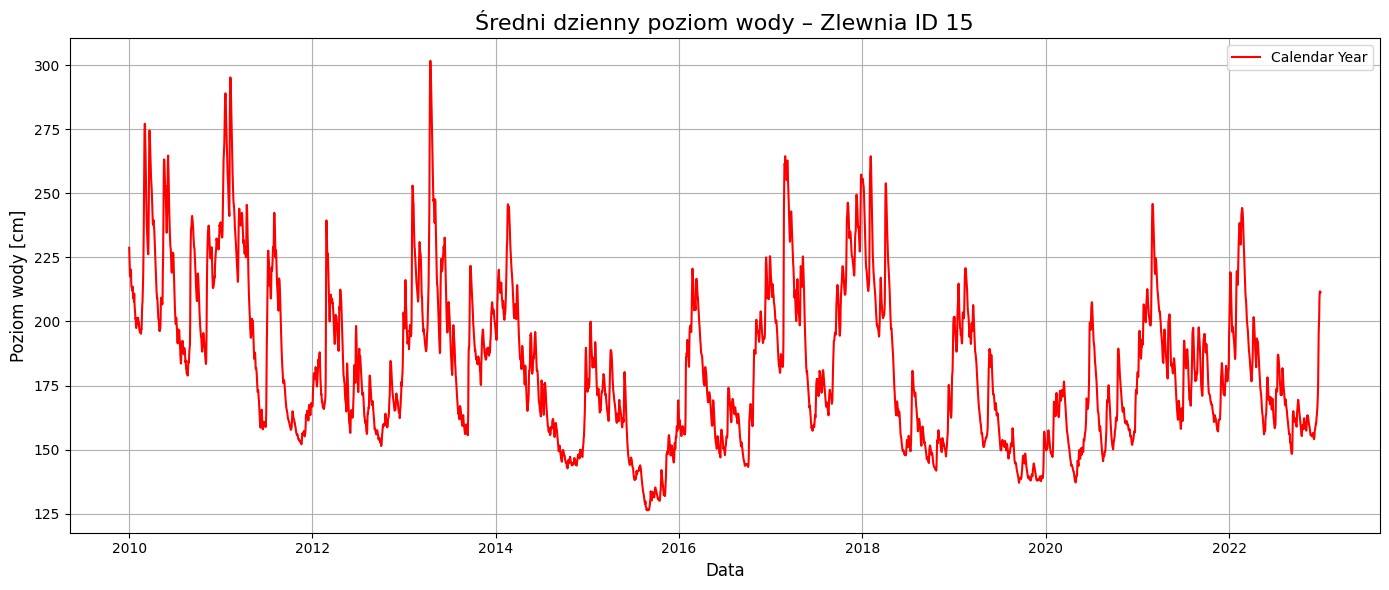

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Water Level"],color='red',label="Calendar Year")
plt.title(f'Średni dzienny poziom wody – Zlewnia ID {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Zdecydowano skupić się na Zlewni numer 16 i porównować jak Ilość Opadów wpływa na Pozimom Wody

In [20]:
# Dołączenie stacji meteo do zlewni
gdf_m_zlewnia = gpd.sjoin(gdf_m, zlewnie, how='inner', predicate='within').drop(['naz_zlewni','id_hyd_10','id_hyd_50','guid'],axis=1)

In [21]:
map_meteo = gdf_m_zlewnia.set_index('Station Code')['Zlewnia ID']
meteo['Zlewnia ID'] = meteo['Station Code'].map(map_meteo)

In [22]:
opad_series = meteo[meteo["Zlewnia ID"] == 16].groupby("Calendar Date")["Daily Precip Sum"].mean().reset_index()

In [23]:
opad_series

,Calendar Date,Daily Precip Sum
0,2010-01-01,0.05
1,2010-01-02,0.45
2,2010-01-03,0.10
3,2010-01-04,0.30
4,2010-01-06,3.50
...,...,...
2326,2022-12-23,3.50
2327,2022-12-24,1.70
2328,2022-12-25,4.90
2329,2022-12-26,3.50


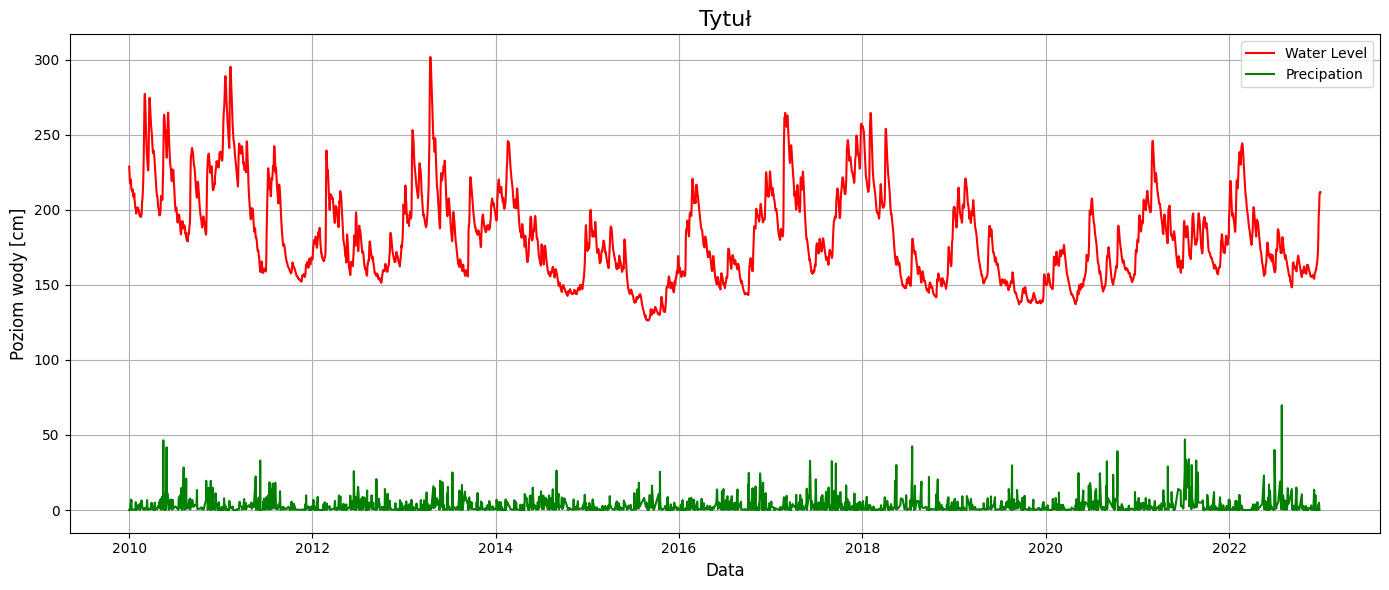

In [24]:
plt.figure(figsize=(14, 6))
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
wl_series2[['Normalized Water Level']] = scaler.fit_transform(wl_series2[['Water Level']])
opad_series[['Normalized Daily Precip Sum']] = scaler.fit_transform(opad_series[['Daily Precip Sum']])

plt.plot(wl_series2["Calendar Date"],wl_series2["Water Level"],color='red',label="Water Level")
plt.plot(opad_series["Calendar Date"],opad_series["Daily Precip Sum"],color='green',label="Precipation")
plt.title('Tytuł', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

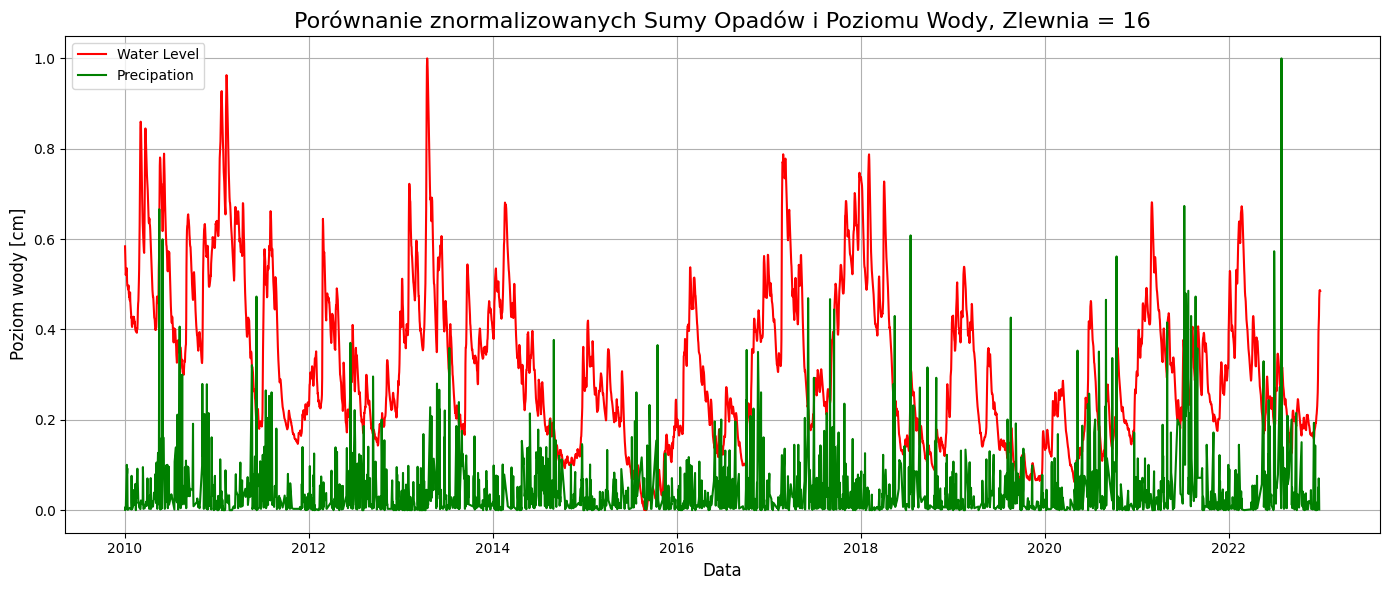

In [25]:
plt.figure(figsize=(14, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Normalized Water Level"],color='red',label="Water Level")
plt.plot(opad_series["Calendar Date"],opad_series["Normalized Daily Precip Sum"],color='green',label="Precipation")
plt.title('Porównanie znormalizowanych Sumy Opadów i Poziomu Wody, Zlewnia = 16', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

### Analiza Lagu Hydroloicznego

💧 Najsilniejsza korelacja = 0.384 przy opóźnieniu 1 dni


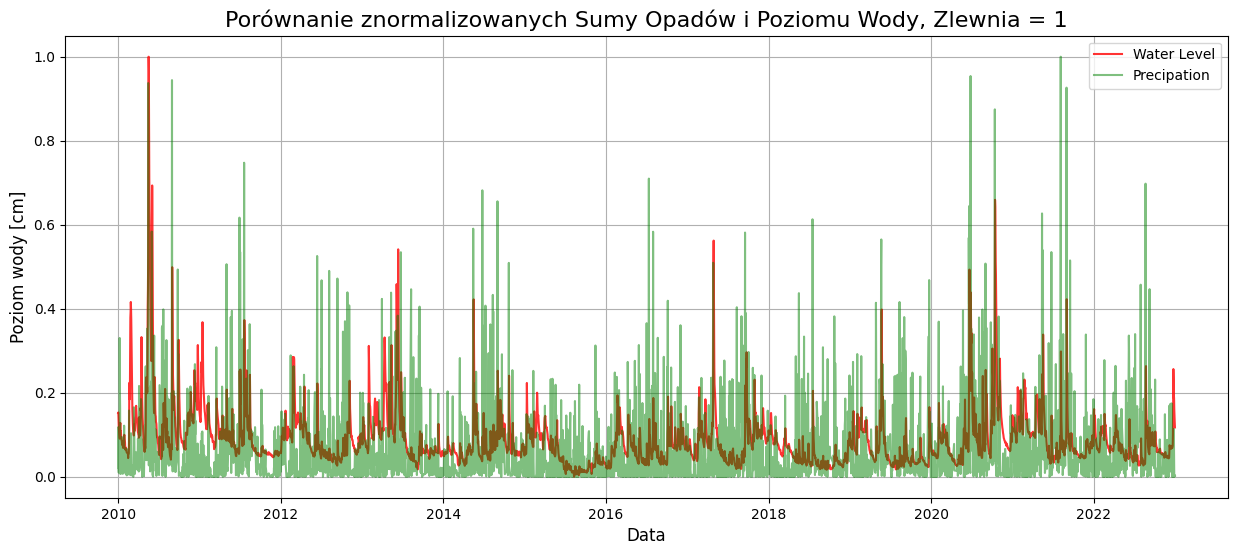

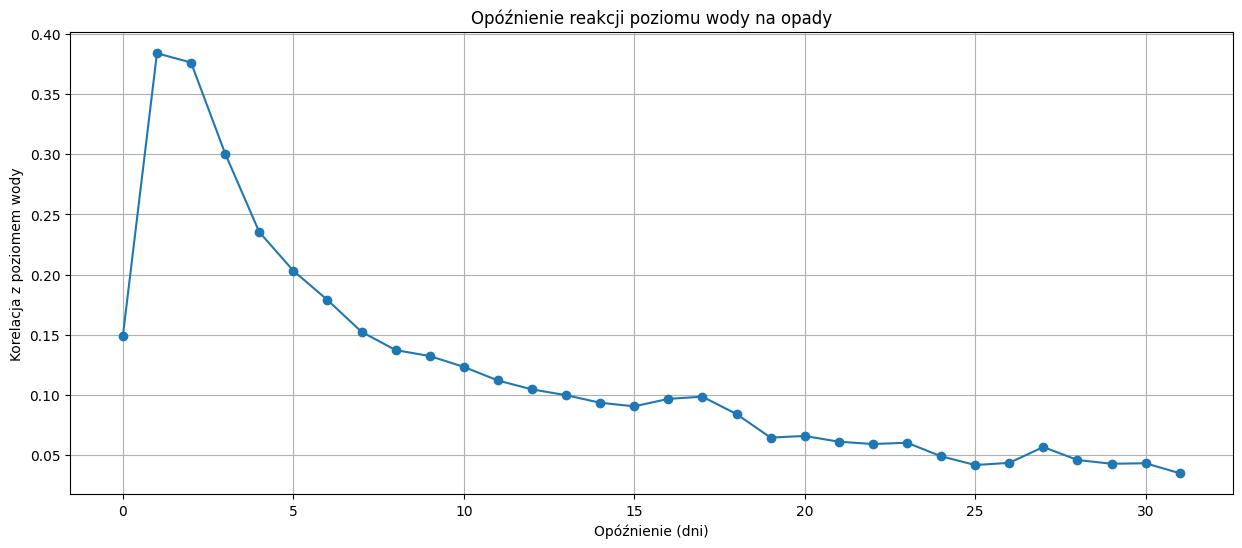

In [31]:
id = 1

wl_series2 = hydro[hydro["Zlewnia ID"] == id].groupby("Calendar Date")["Water Level"].mean().reset_index()
opad_series = meteo[meteo["Zlewnia ID"] == id].groupby("Calendar Date")["Daily Precip Sum"].mean().reset_index()
scaler = MinMaxScaler()
wl_series2[['Normalized Water Level']] = scaler.fit_transform(wl_series2[['Water Level']])
opad_series[['Normalized Daily Precip Sum']] = scaler.fit_transform(opad_series[['Daily Precip Sum']])


# 1. Połącz dane na wspólnych datach (dla bezpieczeństwa)
merged = pd.merge(opad_series, wl_series2, on="Calendar Date", how="inner")

# 2. Ustal zakres opóźnień do sprawdzenia (np. do 20 dni)
max_lag = 31
correlations = []

# 3. Oblicz korelacje opóźnionych serii
for lag in range(0, max_lag + 1):
    shifted_precip = merged["Daily Precip Sum"].shift(lag)
    corr = shifted_precip.corr(merged["Water Level"])
    correlations.append((lag, corr))

# 4. Znajdź najlepszy lag
best_lag, best_corr = max(correlations, key=lambda x: abs(x[1]))

print(f"💧 Najsilniejsza korelacja = {best_corr:.3f} przy opóźnieniu {best_lag} dni")

plt.figure(figsize=(15, 6))
plt.plot(wl_series2["Calendar Date"],wl_series2["Normalized Water Level"],color='red',label="Water Level",alpha=0.8)
plt.plot(opad_series["Calendar Date"],opad_series["Normalized Daily Precip Sum"],color='green',label="Precipation",alpha=0.5)
plt.title(f'Porównanie znormalizowanych Sumy Opadów i Poziomu Wody, Zlewnia = {id}', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Poziom wody [cm]', fontsize=12)
plt.grid(True)
plt.legend()

# 5. Wykres korelacji
plt.figure(figsize=(15, 6))
lags, corr_vals = zip(*correlations)
plt.plot(lags, corr_vals, marker='o')
plt.xlabel("Opóźnienie (dni)")
plt.ylabel("Korelacja z poziomem wody")
plt.title("Opóźnienie reakcji poziomu wody na opady")
plt.grid(True)
plt.show()

